<a href="https://colab.research.google.com/github/Iyad-Alhasan/FHE_Expirements/blob/main/CKKS_Iyad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Following Blocks Implement Encoding as a  class, Source:** [CKKS explained series by Daniel Huynh](https://blog.openmined.org/ckks-explained-part-2-ckks-encoding-and-decoding/)

In [ ]:
!pip3 install fastcore
import numpy as np
from numpy.polynomial import Polynomial
from fastcore.foundation import patch_to

class CKKSEncoder:

    def __init__(self, M:int, scale:float):

      self.xi = np.exp(2 * np.pi * 1j / M)
      self.M = M
      self.create_sigma_R_basis()
      self.scale = scale

    @staticmethod
    def vandermonde(xi: np.complex128, M: int) -> np.array:
        """Computes the Vandermonde matrix from a m-th root of unity."""

        N = M //2
        matrix = []
        # We will generate each row of the matrix
        for i in range(N):
            # For each row we select a different root
            root = xi ** (2 * i + 1)
            row = []

            # Then we store its powers
            for j in range(N):
                row.append(root ** j)
            matrix.append(row)
        return matrix

    def sigma_inverse(self, b: np.array) -> Polynomial:
        """Encodes the vector b in a polynomial using an M-th root of unity."""

        # First we create the Vandermonde matrix
        A = CKKSEncoder.vandermonde(self.xi, M)

        # Then we solve the system
        coeffs = np.linalg.solve(A, b)

        # Finally we output the polynomial
        p = Polynomial(coeffs)
        return p

    def sigma(self, p: Polynomial) -> np.array:
        """Decodes a polynomial by applying it to the M-th roots of unity."""

        outputs = []
        N = self.M //2

        # We simply apply the polynomial on the roots
        for i in range(N):
            root = self.xi ** (2 * i + 1)
            output = p(root)
            outputs.append(output)
        return np.array(outputs)


In [ ]:
@patch_to(CKKSEncoder)
def pi(self, z: np.array) -> np.array:
    """Projects a vector of H into C^{N/2}."""

    N = self.M // 4
    return z[:N]

@patch_to(CKKSEncoder)
def pi_inverse(self, z: np.array) -> np.array:
    """Expands a vector of C^{N/2} by expanding it with its
    complex conjugate."""

    z_conjugate = z[::-1]
    z_conjugate = [np.conjugate(x) for x in z_conjugate]
    return np.concatenate([z, z_conjugate])

In [ ]:
@patch_to(CKKSEncoder)
def create_sigma_R_basis(self):
    """Creates the basis (sigma(1), sigma(X), ..., sigma(X** N-1))."""

    self.sigma_R_basis = np.array(self.vandermonde(self.xi, self.M)).T

In [ ]:
@patch_to(CKKSEncoder)
def compute_basis_coordinates(self, z):
    """Computes the coordinates of a vector with respect to the orthogonal lattice basis."""
    output = np.array([np.real(np.vdot(z, b) / np.vdot(b,b)) for b in self.sigma_R_basis])
    return output

def round_coordinates(coordinates):
    """Gives the integral rest."""
    coordinates = coordinates - np.floor(coordinates)
    return coordinates

def coordinate_wise_random_rounding(coordinates):
    """Rounds coordinates randonmly."""
    r = round_coordinates(coordinates)
    f = np.array([np.random.choice([c, c-1], 1, p=[1-c, c]) for c in r]).reshape(-1)

    rounded_coordinates = coordinates - f
    rounded_coordinates = [int(coeff) for coeff in rounded_coordinates]
    return rounded_coordinates

@patch_to(CKKSEncoder)
def sigma_R_discretization(self, z):
    """Projects a vector on the lattice using coordinate wise random rounding."""
    coordinates = self.compute_basis_coordinates(z)

    rounded_coordinates = coordinate_wise_random_rounding(coordinates)
    y = np.matmul(self.sigma_R_basis.T, rounded_coordinates)
    return y

In [ ]:
@patch_to(CKKSEncoder)
def encode(self, z: np.array) -> Polynomial:
    """Encodes a vector by expanding it first to H,
    scale it, project it on the lattice of sigma(R), and performs
    sigma inverse.
    """
    pi_z = self.pi_inverse(z)
    scaled_pi_z = self.scale * pi_z
    rounded_scale_pi_zi = self.sigma_R_discretization(scaled_pi_z)
    p = self.sigma_inverse(rounded_scale_pi_zi)

    # We round it afterwards due to numerical imprecision
    coef = np.round(np.real(p.coef)).astype(int)
    p = Polynomial(coef)
    return p

@patch_to(CKKSEncoder)
def decode(self, p: Polynomial) -> np.array:
    """Decodes a polynomial by removing the scale,
    evaluating on the roots, and project it on C^(N/2)"""
    rescaled_p = p / self.scale
    z = self.sigma(rescaled_p)
    pi_z = self.pi(z)
    return pi_z

NTT & INTT Transforms Functions definition.
Inputs:  

*   Polynomial to transform (poly)
*   Coefficients' Modulus (mod)



In [ ]:
!pip install galois
import galois

def NTT_transform(poly,mod):
    """ Perform the Number Theoretic Transform (NTT) on the input polynomial. """
    return galois.ntt(poly,modulus=mod)

def iNTT_transform(poly,mod):
    """ Perform the inverse Number Theoretic Transform (iNTT) on the input polynomial. """
    return galois.intt(poly,modulus=mod)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 28.2 MB/s eta 0:00:00


Modular Multiplicative inverse of a number function & subfunctions definitions. Inputs:

*   Number which the multiplicative inverse needed (A)
*   Modulus (M)

Note: A & M has to be co-prime (prime with respect to each other)
Source of this block of code: [Ravi Ojha, rookies lab](https://www.rookieslab.com/posts/how-to-find-multiplicative-inverse-of-a-number-modulo-m-in-python-cpp)

In [ ]:
def modulo_multiplicative_inverse(A, M):
    """
    Assumes that A and M are co-prime
    Returns multiplicative modulo inverse of A under M
    """
    # Find gcd using Extended Euclid's Algorithm
    gcd, x, y = extended_euclid_gcd(A, M)

    # In case x is negative, we handle it by adding extra M
    # Because we know that multiplicative inverse of A in range M lies
    # in the range [0, M-1]
    if x < 0:
        x += M

    return x

def extended_euclid_gcd(a, b):
    """
    Returns a list `result` of size 3 where:
    Referring to the equation ax + by = gcd(a, b)
        result[0] is gcd(a, b)
        result[1] is x
        result[2] is y
    """
    s = 0; old_s = 1
    t = 1; old_t = 0
    r = b; old_r = a

    while r != 0:
        quotient = old_r//r # In Python, // operator performs integer or floored division
        # This is a pythonic way to swap numbers
        # See the same part in C++ implementation below to know more
        old_r, r = r, old_r - quotient*r
        old_s, s = s, old_s - quotient*s
        old_t, t = t, old_t - quotient*t
    return [old_r, old_s, old_t]

Functions to perform operations (multiplication/Mod) element wise inside a list (Polynomials are represented by lists in parts of this code where the element on index $i$ is the coefficient of $X^i$). Inputs:

*   List to operate on element-wise (lst).
*   Constant to multiply/mod with (constant).



In [ ]:
def multiply_by_constant(lst, constant):
    return [x * constant for x in lst]

def mod_list_elements(lst, constant):
    return [x % constant for x in lst]

Converting a polynomial to RNS view function definition. Basically, RNS view is a way to represent polynomial whose coefficients has a huge modulus (requires more than 64 bits) into multiple polyomials where each one's cofficients are modular to one of the prime numbers that make up that huge Modulus (i.e if coefficients modulus is 21, then in RNS view we will get two polynomials where coeffiecients of one are mod 3 and coefficients of the other are mod 7).

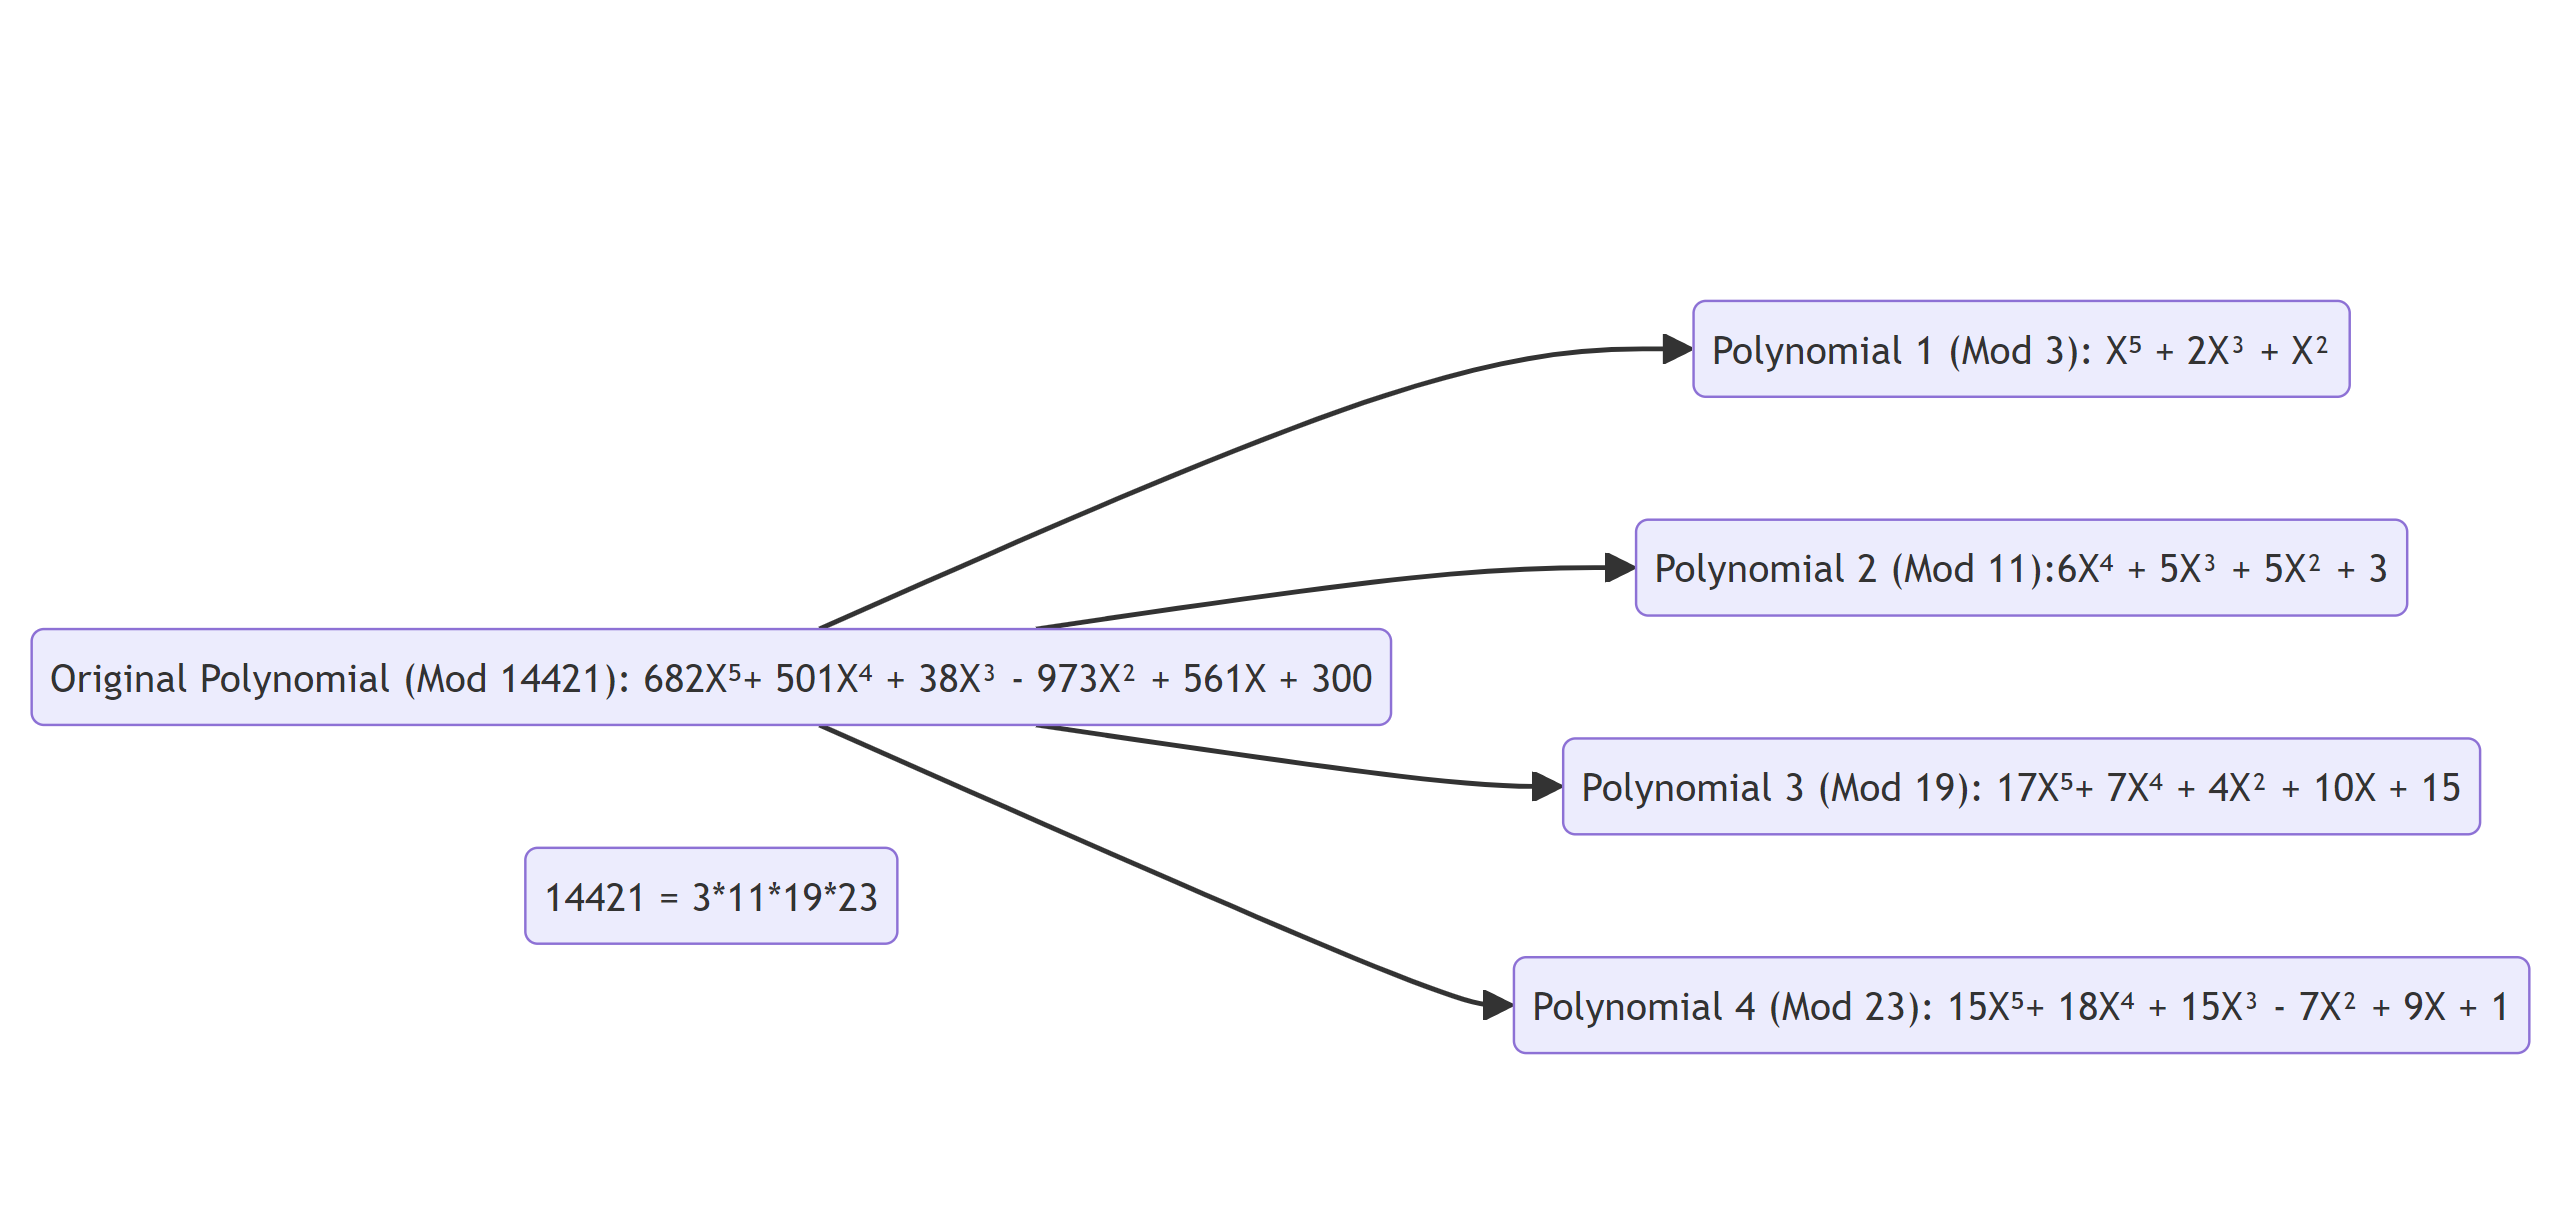


Inputs:

*   Polynomial to convert to RNS View (poly)
*   Basis (prime numbers that make up the number) for the original modulus (RNS_Basis)



In [ ]:
def RNS_view(poly, RNS_Basis):
    matrix = []
    for y in RNS_Basis:
        row = [x % y for x in poly]
        matrix.append(row)
    return matrix

The following block defines functions to calculate parameters needed when performing different CKKS operations. parameters are:

* list of Moduli for each digit: $
C' = \{Q_j\}_{0 \leq j < \text{dnum}} = \left[ \prod_{i=j\alpha}^{(j+1)\alpha-1} q_i \right]_{0 \leq j < \text{dnum}}
$

*   List of basis that comprise each Digit $Q$ ( list of basis $ q $ in each $ Q_j $)

*   function to compute $\hat{Q}_j = \prod_{i \neq j} Q_i$ (Same function can be used to calculate $\hat{p},\hat{q}$ despite its naming stating $\hat{Q}$). Note that the function takes in a list of $Q_i$ and calculates all $\hat{Q}_j$






In [ ]:
def calculate_each_digit_Q(q):
    Q_List = []
    for j in range(dnum):
        start_index = j * alpha
        end_index = (j + 1) * alpha
        Q_List.append(q[start_index:end_index])
    return Q_List


def calculate_C_prime(q):
    C_prime = []
    for j in range(dnum):
        start_index = j * alpha
        end_index = (j + 1) * alpha
        product = np.prod(q[start_index:end_index])
        C_prime.append(product)
    return C_prime


def calculate_q_hat(q, length):
    q_hat = []
    for j in range(length):
        product = np.prod([q[i] for i in range(len(q)) if i != j])
        q_hat.append(product)
    return q_hat

 **Following blocks are CKKS Routines defined defined at** [Better Bootstrapping for Approximate Homomorphic Encryption](https://eprint.iacr.org/2019/688.pdf) **&** [On Architecting Fully Homomorphic Encryption-based Computing Systems](https://link.springer.com/book/10.1007/978-3-031-31754-5)

In [ ]:
def automorph(poly, k, N):
    new_poly = [0] * len(poly)
    for i in range(len(poly)):
        new_index = (5**k * i) % N
        new_poly[new_index] = poly[i]
    return new_poly

In [ ]:
import numpy as np

def decomp(x, Q_Basis,Qhat):
    """
    Decomposes the polynomial x into dnum digits for key switching matrix. IMPORTANT!!: x here is a polynomial in RNS View
    """

   # print (l+1, alpha*beta-1)
    Q_prime = 1
    for i in range(l+1, alpha*beta): #values from l+1 to alph*beta-1
      Q_prime  *= Q_Basis[i]
    #print (Q_prime)

    a_prime = [[0 for _ in range(alpha)] for _ in range(beta)]

    for j in range(beta):
        for i in range(alpha):
            if j * alpha + i <= l:
                QQ = Q_prime%Q_Basis[j*alpha+i]
                a_prime[j][i] = mod_list_elements(multiply_by_constant(x[j * alpha + i] , QQ),Q_Basis[j*alpha+i])
            else:
                a_prime[j][i] = np.zeros(len(Q_Basis))

    for j in range(beta):
        for i in range(alpha):
            if j * alpha + i <= l:
                Q_hat_inverse = modulo_multiplicative_inverse(Qhat[j], Q_Basis[j*alpha+i])%Q_Basis[j*alpha+i]

                a_prime[j][i] = mod_list_elements(multiply_by_constant( a_prime[j][i] ,Q_hat_inverse), Q_Basis[j*alpha+i])

    return a_prime


In [ ]:
def New_Limb(x,Original_Basis,New_Basis,Number_of_Polys,Original_Basis_hat,Original_Basis_hat_Inverse):
      from operator import add
      newlimbs=[]
      sum = [0 for _ in range(len(x[0]))]

      for jj in range(Number_of_Polys):
          term=multiply_by_constant(mod_list_elements(multiply_by_constant(x[jj] , Original_Basis_hat_Inverse[jj]),Original_Basis[jj]),Original_Basis_hat[jj])
          sum = list(map(add,sum,term))
      for i in range(len(New_Basis)):
        moded_sum = mod_list_elements(sum , New_Basis[i])
        newlimbs.append(moded_sum)

      return newlimbs

In [ ]:
def ModUpnew (x,Q_Basis,P_Basis):
  result=[0 for _ in range(beta)]
  for j in range(beta):
    list_of_added_basis = [item for i, sublist in enumerate(Digit_Qs) if i != j for item in sublist]
    concatenated_list = [*list_of_added_basis, *P_Basis]

    temp=New_Limb(x[j],Digit_Qs[j],concatenated_list,alpha,Digit_qhat[j],Digit_qhat_inverse[j])
    #temp.insert(j,x[j])
    result[j] = temp[:j] + x[j] + temp[j:]
   # print (f"\ncurrent digit basis for digit {j} {Digit_Qs[j]}\nList of remaining basis {concatenated_list} \nNew Limbs: {temp}\nOld Limbs: {x[j]}\n\nTotal Limbs for this digit: {result[j]}")
  return result


In [ ]:
def ModDownNew(x,Q_Basis,P_Basis,P):
  from operator import sub

  xfinal=[ 0 for _ in range(len(Q_Basis))]

  for j in range(len(Q_Basis)):
    P_polys=x[L:L+k]
    #print ("P Polys: ", x[L:L+k])
    xhat = New_Limb(P_polys,P_Basis,Q_Basis,k,Digit_phat,Digit_phat_inverse)
    P_inverse= modulo_multiplicative_inverse(P,Q_Basis[j])
    ss = multiply_by_constant((list(map(sub,x[j],xhat[j]))),P_inverse)
    temp=mod_list_elements(ss,Q_Basis[j])
    xfinal[j] = temp
  return xfinal

In [ ]:

# def ModUp(x,Q_Basis,P_Basis):

#   for j in range(beta):
#     temp=New_Limb(x[j],Digit_Qs[j],P_Basis,alpha,Digit_qhat[j],Digit_qhat_inverse[j])
#     x[j]= temp + x[j]
#   return x

In [ ]:
# def ModDown(x,Q_Basis,P_Basis,P):
#   from operator import sub

#   xfinal=[[0 for _ in range(alpha)] for _ in range(beta)]

#   for j in range(beta):
#     P_polys=x[j][0:k]
#     xhat = New_Limb(P_polys,P_Basis,Digit_Qs[j],k,Digit_phat,Digit_phat_inverse)

#     for i in range(len(Digit_Qs[0])):
#       P_inverse= modulo_multiplicative_inverse(P,Digit_Qs[j][i])
#       ss = multiply_by_constant((list(map(sub,x[j][i+k],xhat[i]))),P_inverse)
#       temp=mod_list_elements(ss,Digit_Qs[j][i])
#       xfinal[j][i] = temp
#   return xfinal



Following Code Block Precomputes Global parameters to be used in different functions. Parameters include:


*   $\alpha$
*   $\beta$
*   $\hat{Q}_j$
*   $\hat{Q}^{-1}_j$
*   $\hat{p}_j$
*   $\hat{p}^{-1}_j$





In [ ]:
def precompute_parameters():
  global Digit_Qs
  global Digit_qhat
  global Digit_qhat_inverse
  global Digit_phat
  global Digit_phat_inverse
  global alpha
  global beta

  alpha = ceil((L + 1) // dnum)
  beta = ceil((l + 1) // alpha)
  Digit_Qs = calculate_each_digit_Q(Q_Basis) #list of qj for each digit
  Digit_qhat = []
  Digit_qhat_inverse = []
  Digit_phat = []
  Digit_phat_inverse = []
  for i in range(len(Digit_Qs)):
    Digit_qhat.append(calculate_q_hat(Digit_Qs[i],len(Digit_Qs[i])))

  for i in range(len(Digit_qhat)):
    temp =[]
    for j in range(len(Digit_qhat[i])):
      temp.append(modulo_multiplicative_inverse(Digit_qhat[i][j], Digit_Qs[i][j]))
    Digit_qhat_inverse.append(temp)


  Digit_phat= calculate_q_hat(P_Basis,k)

  for j in range(k):
    Digit_phat_inverse.append(modulo_multiplicative_inverse(Digit_phat[j], P_Basis[j]))




**Following block sets up global parameters and starts using CKKS Routines**

In [ ]:
import numpy as np
from math import ceil
Q_Basis = [5,11,17,23]
P_Basis = [47,51]
global dnum
global L
global k
global l
dnum =2

c0 = [300] # Ciphertext c0
L = len(Q_Basis)
k= len(P_Basis)
l = L

Q= 1
P=1
precompute_parameters()

print(P_Basis)
print(Digit_phat)
print(Digit_phat_inverse)

for number in Q_Basis:
    Q *= number
for number in P_Basis:
    P *= number
#print ("Modulus:", Modulus)

c0_RNS=RNS_view (c0, Q_Basis)




CPrime = calculate_C_prime (Q_Basis )
Qhat = calculate_q_hat (CPrime, dnum)

print(f"Params: L: {L} l: {l} dnum: {dnum} Alpha: {alpha} , beta: {beta}\nQ_Bases: {Q_Basis}\nP_Bases: {P_Basis}\nCPrime {CPrime}\nQhat: {Qhat}\nc0_RNS: {c0_RNS}")

decomposed_c0 = decomp(c0_RNS, Q_Basis,Qhat)
print ("decomposed_c0:",decomposed_c0)


c0p=ModUpnew(decomposed_c0,Q_Basis,P_Basis)
print("c0p:",c0p)

combined_result =c0p[0]
for j in range(1, beta):
    combined_result = [[a + b for a, b in zip(sublist1, sublist2)] for sublist1, sublist2 in zip(combined_result, c0p[j])]



print ("combined_result:",combined_result)

#c0p = ModUp(decomposed_c0,Q_Basis,P_Basis)
#print("c0 for P basis", c0p)
#print("added limbs", c0p[0][0:k])

c0rest=ModDownNew(combined_result,Q_Basis,P_Basis,P)

print("c0 after modding down", c0rest)

[47, 51]
[51, 47]
[12, 38]
Params: L: 4 l: 4 dnum: 2 Alpha: 2 , beta: 2
Q_Bases: [5, 11, 17, 23]
P_Bases: [47, 51]
CPrime [55, 391]
Qhat: [391, 55]
c0_RNS: [[0], [3], [11], [1]]
decomposed_c0: [[[0], [6]], [[7], [18]]]
c0p: [[[0], [6], [16], [4], [3], [50]], [[2], [7], [18], [3], [9], [24]]]
combined_result: [[2], [13], [34], [7], [12], [74]]
c0 after modding down [[0], [7], [0], [20]]


**WIP**

In [ ]:
# Define beta and c0p
beta = 3  # This will result in two iterations: j=0 and j=1
c0p = [
    [[1, 2], [3, 4]],  # This is c0p[0]
    [[5, 6], [7, 8]],  # This is c0p[1]
    [[9, 10], [11, 12]]  # This is c0p[2]
]

# Initialize combined_result with the first sublist (c0p[0])
combined_result =[[0 for _ in range(len(c0p[0]))] for _ in range(beta)]
for j in range(0, beta):
    combined_result = [[a + b for a, b in zip(sublist1, sublist2)] for sublist1, sublist2 in zip(combined_result, c0p[j])]
print(f"Combined result: {combined_result}")


Combined result: [[15, 18], [21, 24]]


In [ ]:
example=RNS_view ([300,561,973,38,501,682], [3,11,19,23])
tt= automorph(example)

TypeError: automorph() missing 2 required positional arguments: 'k' and 'N'

***(WIP)Double check your new limb implementation by solving by hand***

In [ ]:
qhh= calculate_q_hat(Q_Basis,len(Q_Basis))
qhinv=[]
for j in range(len(Q_Basis)):
  qhinv.append(modulo_multiplicative_inverse(qhh[j], Q_Basis[j]))
print (f"q hat: {qhh}\nqinv: {qhinv}")
New_Limb(c0_RNS,Q_Basis,P_Basis,L,qhh,qhinv)

In [ ]:
def modular_inverse(a, m):
    m0, x0, x1 = m, 0, 1
    if m == 1:
        return 0
    while a > 1:
        q = a // m
        m, a = a % m, m
        x0, x1 = x1 - q * x0, x0
    if x1 < 0:
        x1 += m0
    return x1

def rns_to_integer(residues, moduli):
    M = 1
    for m in moduli:
        M *= m

    x = 0
    for i in range(len(moduli)):
        Mi = M // moduli[i]
        yi = modular_inverse(Mi, moduli[i])
        x += residues[i] * Mi * yi

    return x % M

# Converting the first element from RNS TO INTEGER AFTER MODDOWN(supposed to be 300)
first_elements = [sublist[0] for sublist in c0rest]
print ("first elements:", first_elements)

result = rns_to_integer(first_elements, Q_Basis)
print(result)

**Creation of Switching Keys (WIP):**

In [ ]:
import numpy as np


def sample_polynomial(degree, modulus):
    """Sample a polynomial with given degree and coefficients mod modulus."""
    return np.random.randint(0, modulus, degree + 1)

def polynomial_mod(poly, modulus):
    """Compute polynomial modulo operation."""
    return np.mod(poly, modulus)

def polynomial_multiply(poly1, poly2, modulus):
    """Multiply two polynomials and take result modulo another polynomial."""
    result = np.polymul(poly1, poly2)
    return polynomial_mod(result, modulus)

# Example parameters (to be replaced with actual ones)
k = 2  # Number of pi moduli
L = 8  # Number of qj moduli
degree = 3  # Polynomial degree
modulus_p = [17, 19, 23]  # Example moduli pi
modulus_q = [29, 31]  # Example moduli qj
total_modulus = modulus_p + modulus_q
print (total_modulus)
# Secret polynomials s1, s2
s2 = [6,9,11,11]  #Original Secret key (s2)
s1 = [11,-9,6,11] #Rotated Secret Key (s1)
P = 17 * 19 * 23
# Sampling a'^(0), ..., a'^(k+L)
a_samples = [sample_polynomial(degree, total_modulus[j]) for j in range(k + L)]
print (a_samples[0])
# Sample error term e'
e_prime =np.poly1d([0,-1,1,1])

# Compute switching key swk
swk = []
n=len(s1)
xN_1 = [1] + [0] * (n-1) + [1]

for i in range(k + L):
    if i < k:
        b_prime = np.polyadd((-1*np.polydiv(polynomial_multiply(a_samples[i], s2, modulus_p[i]),xN_1)) , e_prime)
        b_prime = polynomial_mod(b_prime, modulus_p[i])
    else:
        PQ = (P%modulus_q[i - k])*(Qhat[i-k]%modulus_q[i - k])
        term1 = -1*np.polydiv(polynomial_multiply(a_samples[i], s2, modulus_q[i - k]),xN_1)[1]
        term2 = np.polydiv((multiply_by_constant(s1,PQ)),xN_1)[1]
        sum1= np.polyadd(term1,term2)
        b_prime = np.polyadd(sum1,e_prime)
        b_prime = polynomial_mod(b_prime, modulus_q[i - k])

    swk.append((b_prime, a_samples[i]))

# Print the switching key
for i, (b, a) in enumerate(swk):
    print(f"swk^{i}: b' = {b}, a' = {a}")